<a href="https://colab.research.google.com/github/NITHISHM2410/Alzheimers-Detection-and-Classification/blob/main/FewShotLearning_Similaity_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import glob
import re
import shutil
import random
import itertools
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 19.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/weights/best_weights_till_now.zip" -d "/content/weights/"

Archive:  /content/drive/MyDrive/weights/best_weights_till_now.zip
  inflating: /content/weights/best_till_now.index  
  inflating: /content/weights/best_till_now.data-00000-of-00001  
  inflating: /content/weights/checkpoint  


LOAD THE MODEL

In [4]:
batch_size = 32

class SQD(tf.keras.layers.Layer):
    def __init__(self):
        super(SQD, self).__init__()
    def call(self, inputs):
        x, y = inputs
        diff = tf.subtract(x, y)
        return tf.square(diff)

def wave_downsample():
    input = tf.keras.Input(batch_size = batch_size,shape = (1024,19))
    output = tf.keras.layers.LSTM(10,return_sequences = True)(input)
    output = tf.keras.layers.Dense(2)(output)
    output = tf.keras.layers.Flatten()(output)
    output = tf.keras.layers.Activation('relu')(output)
    output = tf.keras.layers.Dropout(0.3)(output)
    output = tf.keras.layers.Dense(20)(output)
    output = tf.keras.layers.Dropout(0.1)(output)
    model = tf.keras.Model(inputs = [input],outputs = [output])
    return model
     
def get_model():
    wave1 = tf.keras.Input(batch_size = batch_size,shape = (1024,19),name = 'wave1')
    wave2 = tf.keras.Input(batch_size = batch_size,shape = (1024,19),name = 'wave2')
    state = tf.keras.Input(batch_size = batch_size,shape = (2,),name = 'state')
    
    output1 = tf.keras.layers.BatchNormalization()(wave1)
    output2 = tf.keras.layers.BatchNormalization()(wave2)

    down_sampler = wave_downsample()
    output1 = down_sampler(output1)
    output2 = down_sampler(output2)

    output1 = tf.keras.layers.Activation('tanh')(output1)
    output1 = tf.keras.layers.Dropout(0.3)(output1)

    output2 = tf.keras.layers.Activation('tanh')(output2)
    output2 = tf.keras.layers.Dropout(0.3)(output2)

    output = SQD()([output1,output2])
    output = tf.keras.layers.concatenate([output,state])
    output = tf.keras.layers.Dense(10)(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid',name = 'difference' )(output)
    
    model = tf.keras.Model(inputs = [wave1,wave2,state],outputs = [output],name = 'FewShot')
    return model

model = get_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001),
              loss = 'binary_crossentropy',
              metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.8),
                         tfa.metrics.F1Score(num_classes=1,threshold = 0.8)])

In [5]:
model.load_weights("/content/weights/best_till_now")

Cleaning data for testing

In [6]:
!unzip "/content/drive/MyDrive/FewShot/FINAL_DATASET.zip"

Archive:  /content/drive/MyDrive/FewShot/FINAL_DATASET.zip
   creating: Dataset/SETA/
  inflating: Dataset/SETA/healthy_open1.csv  
  inflating: Dataset/SETA/healthy_open10.csv  
  inflating: Dataset/SETA/healthy_open11.csv  
  inflating: Dataset/SETA/healthy_open12.csv  
  inflating: Dataset/SETA/healthy_open2.csv  
  inflating: Dataset/SETA/healthy_open3.csv  
  inflating: Dataset/SETA/healthy_open4.csv  
  inflating: Dataset/SETA/healthy_open5.csv  
  inflating: Dataset/SETA/healthy_open6.csv  
  inflating: Dataset/SETA/healthy_open7.csv  
  inflating: Dataset/SETA/healthy_open8.csv  
  inflating: Dataset/SETA/healthy_open9.csv  
   creating: Dataset/SETB/
  inflating: Dataset/SETB/healthy_closed1.csv  
  inflating: Dataset/SETB/healthy_closed10.csv  
  inflating: Dataset/SETB/healthy_closed11.csv  
  inflating: Dataset/SETB/healthy_closed12.csv  
  inflating: Dataset/SETB/healthy_closed2.csv  
  inflating: Dataset/SETB/healthy_closed3.csv  
  inflating: Dataset/SETB/healthy_closed4

In [7]:
files = glob.glob("/content/Dataset/*/*")
files

['/content/Dataset/SETB/healthy_closed1.csv',
 '/content/Dataset/SETB/healthy_closed4.csv',
 '/content/Dataset/SETB/healthy_closed9.csv',
 '/content/Dataset/SETB/healthy_closed5.csv',
 '/content/Dataset/SETB/healthy_closed12.csv',
 '/content/Dataset/SETB/healthy_closed2.csv',
 '/content/Dataset/SETB/healthy_closed11.csv',
 '/content/Dataset/SETB/healthy_closed8.csv',
 '/content/Dataset/SETB/healthy_closed6.csv',
 '/content/Dataset/SETB/healthy_closed10.csv',
 '/content/Dataset/SETB/healthy_closed3.csv',
 '/content/Dataset/SETB/healthy_closed7.csv',
 '/content/Dataset/SETD/alzeimer_closed1.csv',
 '/content/Dataset/SETD/alzeimer_closed12.csv',
 '/content/Dataset/SETD/alzeimer_closed8.csv',
 '/content/Dataset/SETD/alzeimer_closed4.csv',
 '/content/Dataset/SETD/alzeimer_closed9.csv',
 '/content/Dataset/SETD/alzeimer_closed6.csv',
 '/content/Dataset/SETD/alzeimer_closed7.csv',
 '/content/Dataset/SETD/alzeimer_closed3.csv',
 '/content/Dataset/SETD/alzeimer_closed2.csv',
 '/content/Dataset/SE

In [8]:
def clean(path):
    df = pd.read_csv(path)
    
    for column in df.columns:
        if df[column].dtype == 'object':
            print("Sample : ",path," feature : ",column," is uncleaned")
            df[column] = pd.to_numeric(df[column], errors='coerce')
            df[column] = df[column].fillna(method='ffill')
            df[column] = df[column].fillna(method='bfill')
    df = df.iloc[:1024,:]

    while df.isnull().sum().values.sum() != 0:
        print("Sample : ",path,"getting cleaned")
        df = df.fillna(method = 'ffill')
        df = df.fillna(method = 'bfill')
    df.to_csv(path, index=False)
     
for i in files:
    clean(i)

Sample :  /content/Dataset/SETB/healthy_closed2.csv  feature :  16  is uncleaned
Sample :  /content/Dataset/SETB/healthy_closed6.csv  feature :  14  is uncleaned
Sample :  /content/Dataset/SETD/alzeimer_closed12.csv  feature :  18  is uncleaned
Sample :  /content/Dataset/SETA/healthy_open2.csv  feature :  16  is uncleaned
Sample :  /content/Dataset/SETA/healthy_open11.csv  feature :  14  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open10.csv  feature :  0  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open10.csv getting cleaned
Sample :  /content/Dataset/SETC/alzeimer_open8.csv  feature :  0  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open8.csv getting cleaned
Sample :  /content/Dataset/SETC/alzeimer_open6.csv  feature :  0  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open6.csv getting cleaned
Sample :  /content/Dataset/SETC/alzeimer_open5.csv  feature :  0  is uncleaned
Sample :  /content/Dataset/SETC/alzeimer_open5.csv getting cleaned


***TESTING TECHNIQUE*** :  There will be a query sample of UNKNOWN CLASS which the model need to predict as Healthy sample or Alzheimer sample. The query sample will be compared against stored reference samples of healthy and Alzheimer samples with the Similarity Few Shot NN trained. The intended results are: 


*   Query Sample belongs to 'Alzheimer' class if Disimilarity score between query sample and Alzheimer reference samples are closer to zero.
*   Query Sample belongs to 'Healthy' class if Dissimilarity score between query sample and healthy reference samples are closer to zero.



Unseen samples will be used to test the similarity. The below samples weren't included in train data as well as the validated data

In [9]:
reference = [] # For Comparing Against
query = [] # Query Samples which are to be detected

unseen_files = ['/content/Dataset/SETC/alzeimer_open7.csv',
 '/content/Dataset/SETC/alzeimer_open12.csv',
 '/content/Dataset/SETC/alzeimer_open2.csv',
 '/content/Dataset/SETD/alzeimer_closed7.csv',
 '/content/Dataset/SETD/alzeimer_closed10.csv',
 '/content/Dataset/SETD/alzeimer_closed9.csv',
 '/content/Dataset/SETA/healthy_open5.csv',
 '/content/Dataset/SETA/healthy_open4.csv',
 '/content/Dataset/SETA/healthy_open9.csv',
 '/content/Dataset/SETB/healthy_closed8.csv',
 '/content/Dataset/SETB/healthy_closed7.csv',
 '/content/Dataset/SETB/healthy_closed3.csv']

for i in range(0,12,3):
    reference += unseen_files[i+1:i+3]
    query.append(unseen_files[i])

In [10]:
healthy = []
alz = []
for afile in reference:
    if "healthy" in afile:
        healthy.append(afile)
    elif "alzeimer" in afile:
        alz.append(afile)    

Query Samples for testing

In [11]:
query

['/content/Dataset/SETC/alzeimer_open7.csv',
 '/content/Dataset/SETD/alzeimer_closed7.csv',
 '/content/Dataset/SETA/healthy_open5.csv',
 '/content/Dataset/SETB/healthy_closed8.csv']

Reference Samples :

In [12]:
healthy,alz

(['/content/Dataset/SETA/healthy_open4.csv',
  '/content/Dataset/SETA/healthy_open9.csv',
  '/content/Dataset/SETB/healthy_closed7.csv',
  '/content/Dataset/SETB/healthy_closed3.csv'],
 ['/content/Dataset/SETC/alzeimer_open12.csv',
  '/content/Dataset/SETC/alzeimer_open2.csv',
  '/content/Dataset/SETD/alzeimer_closed10.csv',
  '/content/Dataset/SETD/alzeimer_closed9.csv'])

Reading a sample

In [13]:
def to_numeric(csv):
    data = pd.read_csv(csv).values
    return data

def pair_up(x1,x2):
        sample = [x1,x2]
        if "closed" in x1:
            sample.append(0)
        elif "open" in x1:
            sample.append(1) 
        if "closed" in x2:
            sample.append(0)
        elif "open" in x2:
            sample.append(1)     

        sample[0] = to_numeric(x1)
        sample[1] = to_numeric(x2)

        return sample 

Getting Sample ready for Model Input

In [14]:
def as_input(sample):
    input = dict()
    input['wave1'] = tf.cast(tf.expand_dims(sample[0],0),dtype = tf.float32)
    input['wave2'] = tf.cast(tf.expand_dims(sample[1],0),dtype = tf.float32)
    input['state'] = tf.cast(tf.expand_dims([sample[2],sample[3]],0),dtype = tf.float32)
    return input

# TESTING 

In [15]:
def get_scores(afile):
    print("Query Sample :",afile)

    healthy_scores = []
    alz_scores = []

    reference_tests = 4 #No of times to compare 
    
    for ref in alz[:reference_tests]:
        pair = pair_up(afile,ref)
        pair = as_input(pair)
        output = np.squeeze(model(pair)).tolist()
        alz_scores.append(output)
        
    for ref in healthy[:reference_tests]:
        pair = pair_up(afile,ref)
        pair = as_input(pair)
        output = np.squeeze(model(pair)).tolist()
        healthy_scores.append(output)

    a_avg,h_avg = sum(alz_scores)/reference_tests,sum(healthy_scores)/reference_tests
    print("Dissimilarity Scores Query vs healthy: ",healthy_scores," Avg :",h_avg)
    print("Dissimilarity Scores Query vs alzheimer: ",alz_scores," Avg :",a_avg)

    if a_avg > h_avg:
        print("Query Sample Class Predicted : Healthy Sample")
    else:
        print("Query Sample Class Predicted : Alzheimer Sample")    

In [16]:
for que in query:
    print("-----------------------------------------------------------------")
    get_scores(que)

-----------------------------------------------------------------
Query Sample : /content/Dataset/SETC/alzeimer_open7.csv
Dissimilarity Scores Query vs healthy:  [0.9986218214035034, 0.9982118606567383, 0.991463840007782, 0.9995662569999695]  Avg : 0.9969659447669983
Dissimilarity Scores Query vs alzheimer:  [0.019527003169059753, 0.020999472588300705, 0.027043895795941353, 0.02164612151682377]  Avg : 0.022304123267531395
Query Sample Class Predicted : Alzheimer Sample
-----------------------------------------------------------------
Query Sample : /content/Dataset/SETD/alzeimer_closed7.csv
Dissimilarity Scores Query vs healthy:  [0.9999897480010986, 0.9999876022338867, 0.9999951124191284, 0.9999914169311523]  Avg : 0.9999909698963165
Dissimilarity Scores Query vs alzheimer:  [0.003701833775267005, 0.001822922844439745, 0.0013239659601822495, 0.002049605129286647]  Avg : 0.0022245819272939116
Query Sample Class Predicted : Alzheimer Sample
----------------------------------------------

IN THE ABOVE RESULTS:

*   Dissimilarity Scores Query vs healthy : Dissimilarity scores when query is compared with reference samples of class 'healthy'.
*   Dissimilarity Scores Query vs alzheimer : Dissimilarity scores when query is compared with reference samples of class 'alzheimer'.

FROM THE ABOVE RESULTS,THE DISSIMILARITY SCORE IS LESS WHEN QUERY AND REFERNCE SAMPLE BELONGS TO THE SAME CLASS AND DISSIMILARITY SCORE IS HIGH WHEN QUERY AND REFERENCE SAMPLES AREN'T FROM THE SAME CLASS,SO **THE TRAINED MODEL IS ABLE TO ACCURATELY CAPTURE AND PREDICT THESE DETAILS.**

# ESTIMATING MODEL'S CONFIDENCE

Based on above results,the model can find the similarity score accurately but confidence score must also be estimated.

To estimate the confidence of the models predictions, monte carlo dropout technqiue is used where dropout is enabled during testing multliple forward passes is made for an input and if the outputs of multiple forward passes are similar or **if their variance is less** then the confidence is said to be high.



Example Query Sample: /content/Dataset/SETA/healthy_open5.csv

Example Reference Samples : 

1.) /content/Dataset/SETA/healthy_open4.csv

2.) /content/Dataset/SETC/alzeimer_open2.csv

In [24]:
query_sample = "/content/Dataset/SETA/healthy_open5.csv"
ref_samples = [
    "/content/Dataset/SETA/healthy_open4.csv",
    "/content/Dataset/SETC/alzeimer_open2.csv"
]
        

In [25]:
t = 20 # no of forward passes

In [26]:
def get_passes(q,r,t):
    outputs = []
    pair = pair_up(q,r)
    pair = as_input(pair)
    for t in range(0,t):
        outputs.append(np.squeeze(model(pair,training = True)).tolist())    
    return outputs,np.var(outputs)

In [27]:
res1,var1 = get_passes(query_sample,ref_samples[0],t)
res2,var2 = get_passes(query_sample,ref_samples[1],t)

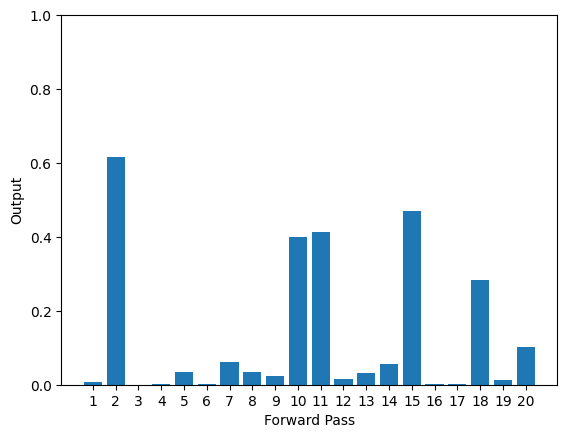

In [28]:
plt.bar(x = [i for i in range(1,t+1)],height = res1,)
plt.xlabel("Forward Pass")
plt.xticks([i for i in range(1,t+1)])
plt.ylim(0,1)
plt.ylabel("Output")
plt.show()

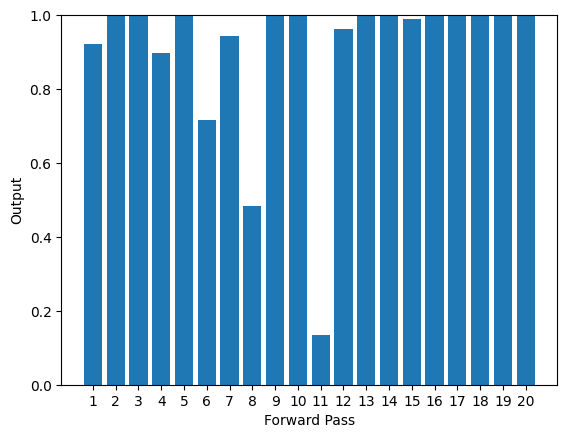

In [29]:
plt.bar(x = [i for i in range(1,t+1)],height = res2)
plt.xlabel("Forward Pass")
plt.ylabel("Output")
plt.xticks([i for i in range(1,t+1)])
plt.ylim(0,1)
plt.show()

In [30]:
print("Variance for predictions are :",var1," ",var2)

Variance for predictions are : 0.03514174758511376   0.04637737851937697


The Variance is measured against a suitable threshold to determine whether the predictions are confident or not.